In [1]:
# Import libraries
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
import os
print(os.listdir("../input"))

['aerial-cactus-identification']


In [2]:
labels = pd.read_csv('../input/aerial-cactus-identification/train.csv')
sub = pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')
train_path = '../input/aerial-cactus-identification/train/train/'
test_path = '../input/aerial-cactus-identification/test/test/'

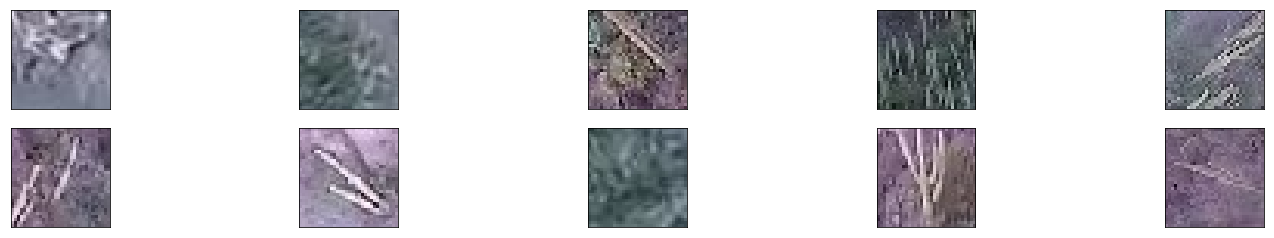

In [3]:
# Display 10 random images
train_dir = os.listdir(train_path)
fig = plt.figure(figsize=(25, 4))
for index, img in enumerate(np.random.choice(train_dir, 10)):
    ax = fig.add_subplot(2, 10//2, index+1, xticks=[], yticks=[])
    img_path = os.path.join(train_path, img)
    image = cv2.imread(img_path)
    plt.imshow(image)

In [4]:
# Print number of training images
print("There are {} training images.".format(len(labels)))

There are 17500 training images.


In [5]:
# Hyper parameters
num_epochs = 6
num_classes = 2
batch_size = 128
learning_rate = 0.001

In [6]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# Create a custom Dataset class
class myDataset(Dataset):
    def __init__(self, csv_file, data_dir = './', transform=None):
        super().__init__()
        self.df = csv_file.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [8]:
# Image transformations for training and test datasets
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Generator for training data
train_dataset = myDataset(csv_file=labels, data_dir=train_path, transform=trans_train)
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [9]:
# Download the VGG19 model
model = models.vgg19(pretrained='imagenet')


# Add a fully connected layer 
num_ftrs = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_ftrs, num_classes)])
model.classifier = nn.Sequential(*features)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:41<00:00, 13.9MB/s]


In [10]:
# Display the model's architecture
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
# Enable the model to run in GPU
model.cuda()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [12]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/6], Step [100/137], Loss: 0.0971
Epoch [2/6], Step [100/137], Loss: 0.0091
Epoch [3/6], Step [100/137], Loss: 0.0054
Epoch [4/6], Step [100/137], Loss: 0.0302
Epoch [5/6], Step [100/137], Loss: 0.0006
Epoch [6/6], Step [100/137], Loss: 0.0077


In [13]:
# Generator for test data
test_dataset = myDataset(csv_file=sub, data_dir=test_path, transform=trans_test)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
# Making predictions on test dataset
# Note: There will be a warning because numpy version 
model.eval()

preds = []
for index, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)
    
    _, predicted = torch.max(output.data, 1)
    for i in predicted.data.cpu().numpy():
        preds.append(i)
#Create a prediction csv file for submission
sub['has_cactus'] = preds
sub.to_csv('sub.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [15]:
# Prediction csv file
sub

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1
7,0061bd302d735db829418cb90b4e6040.jpg,1
8,00754573d8c7223e73da553dd43780bd.jpg,1
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0
